In [26]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error


In [27]:
df = pd.read_csv(r'/workspaces/carlos060495-intro-ml/data/raw/medical_insurance_cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 1.1 Busqueda y eliminacion datos unicos

In [29]:
unicos = df.nunique()
unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [30]:
df[unicos[unicos == 1].index]

""
0
1
2
3
4
...
1333
1334
1335
1336


No se encontraron con valores unicos

# 1.2 Busqueda y eliminacion datos duplicados en filas y columnas

In [31]:
df.duplicated().sum()

np.int64(1)

In [32]:
df[df.duplicated(keep=False)]


,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [33]:
# Se encontro una fila duplicada y se procede a su eliminacion
df = df.drop_duplicates()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [34]:
df.T.duplicated().sum()

np.int64(0)

No se encontraron columnas con valores duplicados

# 1.3 Busqueda de valores faltantes y nulos

In [35]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# 1.3.1 Busqueda profunda de valores faltantes

In [36]:
# Ahora vamos a ver que valores únicos tiene cada columna de texto. Esto nos ayudará a identificar valores sospechosos.
for columna in df.select_dtypes(include='object').columns: # → Recorre todas las columnas de texto
    print(f"\n{'-'*25}")
    print(f"COLUMNA: {columna}")
    print(f"{'-'*25}")
    print(df[columna].value_counts()) # Muestra cada valor único y cuántas veces aparece, ordenado de mayor a menor frecuencia
    print(f"\nTotal de valores únicos: {df[columna].nunique()}") # → Cuenta cuántos valores diferentes hay en total


-------------------------
COLUMNA: sex
-------------------------
sex
male      675
female    662
Name: count, dtype: int64

Total de valores únicos: 2

-------------------------
COLUMNA: smoker
-------------------------
smoker
no     1063
yes     274
Name: count, dtype: int64

Total de valores únicos: 2

-------------------------
COLUMNA: region
-------------------------
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

Total de valores únicos: 4


En la busqueda profunda no se encontraron faltantes ocultos

<Axes: >

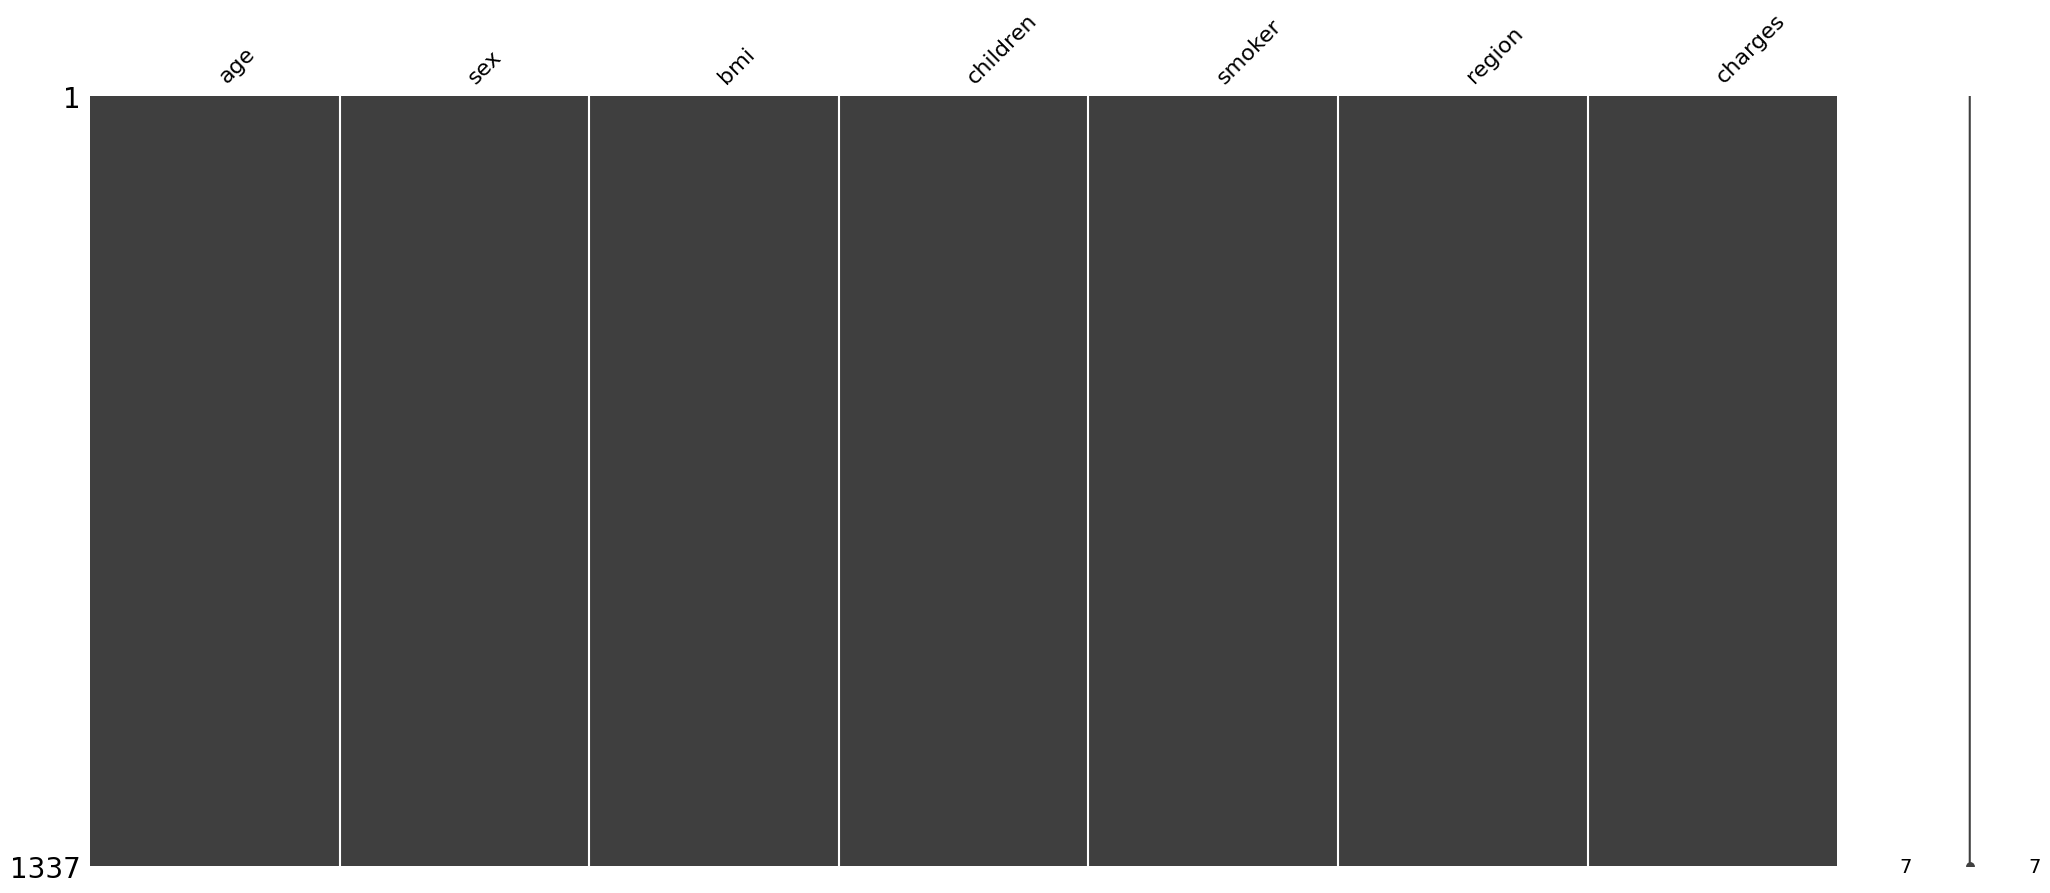

In [37]:
msno.matrix(df)

# 2.1 Codificacion de variables categoricas

In [38]:
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


# 2.2 Outliers

In [39]:
# ============================================================================
# CALCULAR OUTLIERS DE FORMA SENCILLA (Método IQR)
# ============================================================================

# Lista de columnas que quiero analizar
columnas = ['age', 'bmi', 'children']

# Para guardar los resultados
resultados = []

# Analizar cada columna una por una
for columna in columnas:
    
    # Obtener los datos de la columna
    datos = df[columna]
    
    # Calcular Q1 (25%), Q3 (75%) y IQR
    Q1 = datos.quantile(0.25)  # 25% de los datos
    Q3 = datos.quantile(0.75)  # 75% de los datos
    IQR = Q3 - Q1              # Diferencia entre Q3 y Q1
    
    # Calcular límites
    limite_bajo = Q1 - 1.5 * IQR
    limite_alto = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_bajos = (datos < limite_bajo).sum()
    outliers_altos = (datos > limite_alto).sum()
    total_outliers = outliers_bajos + outliers_altos
    
    # Calcular porcentaje
    porcentaje = (total_outliers / len(datos)) * 100
    
    # Guardar en la lista
    resultados.append({
        'Columna': columna,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite_Bajo': limite_bajo,
        'Limite_Alto': limite_alto,
        'Total_Outliers': total_outliers,
        'Porcentaje': round(porcentaje, 2)
    })

# Convertir a DataFrame para verlo bonito
df_outliers = pd.DataFrame(resultados)

# Mostrar resultados
print("="*80)
print("ANÁLISIS DE OUTLIERS")
print("="*80)
print(df_outliers)
print("="*80)

# Explicar qué significa
print("\n💡 INTERPRETACIÓN:")
for i in range(len(df_outliers)):
    col = df_outliers.loc[i, 'Columna']
    limite_bajo = df_outliers.loc[i, 'Limite_Bajo']
    limite_alto = df_outliers.loc[i, 'Limite_Alto']
    total = df_outliers.loc[i, 'Total_Outliers']
    pct = df_outliers.loc[i, 'Porcentaje']
    
    print(f"\n{col}:")
    print(f"  - Valores normales: entre {limite_bajo:.1f} y {limite_alto:.1f}")
    print(f"  - Outliers encontrados: {total} ({pct}%)")
    
    if pct < 5:
        print(f"  ✅ Pocos outliers, está bien")
    elif pct < 10:
        print(f"  ⚠️ Algunos outliers")
    else:
        print(f"  ❌ Muchos outliers")

ANÁLISIS DE OUTLIERS
    Columna     Q1    Q3  ...  Limite_Alto  Total_Outliers  Porcentaje
0       age  27.00  51.0  ...       87.000               0        0.00
1       bmi  26.29  34.7  ...       47.315               9        0.67
2  children   0.00   2.0  ...        5.000               0        0.00

[3 rows x 8 columns]

💡 INTERPRETACIÓN:

age:
  - Valores normales: entre -9.0 y 87.0
  - Outliers encontrados: 0 (0.0%)
  ✅ Pocos outliers, está bien

bmi:
  - Valores normales: entre 13.7 y 47.3
  - Outliers encontrados: 9 (0.67%)
  ✅ Pocos outliers, está bien

children:
  - Valores normales: entre -3.0 y 5.0
  - Outliers encontrados: 0 (0.0%)
  ✅ Pocos outliers, está bien


# 3.1 Verificacion para regresion lineal

Antes de entrenar el modelo final, verificamos los supuestos de la regresión lineal usando OLS de statsmodels. **Importante:** Creamos una copia separada (`X_ols`) con la constante solo para este análisis estadístico, sin modificar el `X` original que usaremos después para el modelado con sklearn.

In [40]:
X = df_encoded.drop(columns='charges')
y = df_encoded['charges']


In [41]:
# Crear una copia de X con la constante solo para el análisis OLS
X_ols = sm.add_constant(X)
model_ols = sm.OLS(y, X_ols)
results = model_ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:47:24   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    988.227  

In [42]:
residuos = results.resid

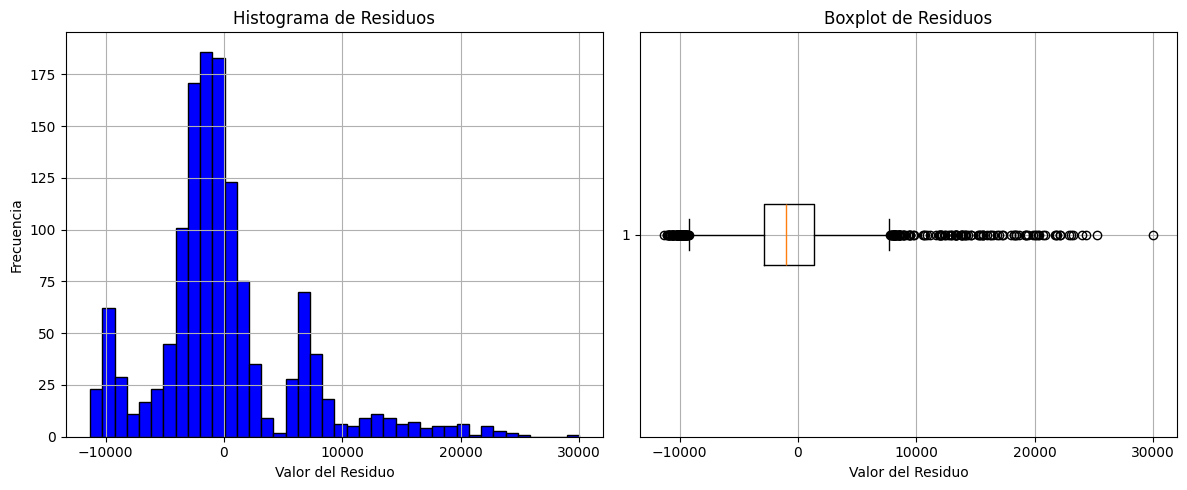

In [43]:
# Crea una figura con dos subgráficos (uno para el histograma y otro para el boxplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

# 4.1 Division de los datos para entrenamiento y test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 4.2 Seleccion de caracteristicas

He decidido mantener todas las características en el modelado porque cada variable aporta información complementaria sobre los costes médicos. Las numéricas continuas reflejan tendencias de salud y edad, mientras que las categóricas codificadas capturan diferencias relevantes entre grupos de pacientes, como el hábito de fumar o la región de residencia. Incluso aquellas variables que parecen menos influyentes pueden contribuir a mejorar la capacidad predictiva del modelo, por lo que conservarlas garantiza un análisis más completo y robusto.

# 4.3 Escalado

In [45]:
# Escalamos los datos con StandardScaler
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 4.4 Entrenamos el Modelo y realizamos pruebas

In [46]:
# Entrenamos un modelo de regresión lineal sin regularización
m_linear = LinearRegression().fit(X_train_sc, y_train)

# Realizamos predicciones sobre el conjunto de entrenamiento y de testeo
yhat_train_linear = m_linear.predict(X_train_sc)
yhat_linear = m_linear.predict(X_test_sc)

# 4.5 Obtenemos las metricas de las pruebas realizadas

In [47]:
def get_metrics(yhat, y_test, yhat_train, y_train):
  metrics_train = r2_score(y_train, yhat_train), median_absolute_error(y_train, yhat_train), mean_absolute_percentage_error(y_train, yhat_train)*100
  metrics_test = r2_score(y_test, yhat), median_absolute_error(y_test, yhat), mean_absolute_percentage_error(y_test, yhat)*100
  metrics_diff = list(map(lambda x: x[1]-x[0], zip(metrics_train, metrics_test)))
  return pd.DataFrame(data=[metrics_train, metrics_test, metrics_diff], columns=['R2', 'Median AE', 'MAPE'], index=['Train set', 'Test set', 'Diferencia'])

In [48]:
get_metrics(yhat_linear, y_test, yhat_train_linear, y_train)

,R2,Median AE,MAPE
Train set,0.748860,2225.724958,40.317138
Test set,0.753039,2164.158234,39.166324
Diferencia,0.004178,-61.566724,-1.150814


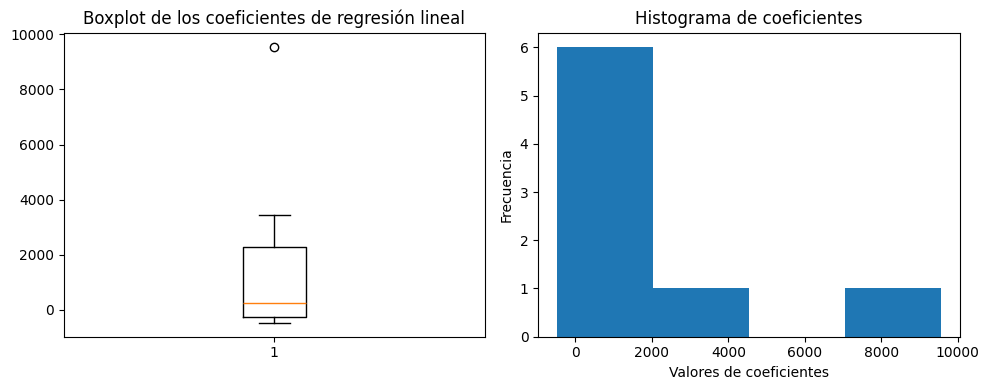

In [49]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_linear.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal')
plt.subplot(1, 2, 2)
plt.hist(m_linear.coef_,'sturges')
plt.xlabel('Valores de coeficientes')
plt.ylabel('Frecuencia')
plt.title('Histograma de coeficientes')
plt.tight_layout()
plt.show()

# 5.1 ¿Por qué no usar búsqueda de hiperparámetros?

En la regresión lineal múltiple clásica no se buscan hiperparámetros, ya que el modelo se ajusta directamente calculando los coeficientes que minimizan el error cuadrático medio mediante una solución analítica. El único aspecto configurable es si se incluye o no el término independiente (fit_intercept), pero fuera de eso el procedimiento es determinista y no requiere validación de parámetros adicionales.
